In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

	float botpres(time_counter, y, x) ;
		botpres:standard_name = "sea_water_pressure_at_sea_floor" ;
		botpres:long_name = "Pressure at sea floor" ;
		botpres:units = "dbar" ;
		botpres:online_operation = "average" ;
		botpres:interval_operation = "120 s" ;
		botpres:interval_write = "1 h" ;
		botpres:cell_methods = "time: mean (interval: 120 s)" ;
		botpres:_FillValue = 1.e+20f ;
		botpres:missing_value = 1.e+20f ;
		botpres:coordinates = "time_centered nav_lon nav_lat" ;

In [2]:
! ncdump -h /ocean/imachuca/Canyons/results_mackenzie/initial_collection/botpress_ideal_half/1_mesh_mask.nc

netcdf \1_mesh_mask {
dimensions:
	x = 244 ;
	y = 274 ;
	z = 80 ;
	t = UNLIMITED ; // (1 currently)
variables:
	float nav_lon(y, x) ;
	float nav_lat(y, x) ;
	float nav_lev(z) ;
	double time_counter(t) ;
	byte tmask(t, z, y, x) ;
	byte umask(t, z, y, x) ;
	byte vmask(t, z, y, x) ;
	byte fmask(t, z, y, x) ;
	byte tmaskutil(t, y, x) ;
	byte umaskutil(t, y, x) ;
	byte vmaskutil(t, y, x) ;
	byte fmaskutil(t, y, x) ;
	float glamt(t, y, x) ;
	float glamu(t, y, x) ;
	float glamv(t, y, x) ;
	float glamf(t, y, x) ;
	float gphit(t, y, x) ;
	float gphiu(t, y, x) ;
	float gphiv(t, y, x) ;
	float gphif(t, y, x) ;
	double e1t(t, y, x) ;
	double e1u(t, y, x) ;
	double e1v(t, y, x) ;
	double e1f(t, y, x) ;
	double e2t(t, y, x) ;
	double e2u(t, y, x) ;
	double e2v(t, y, x) ;
	double e2f(t, y, x) ;
	double ff(t, y, x) ;
	short mbathy(t, y, x) ;
	short misf(t, y, x) ;
	float isfdraft(t, y, x) ;
	double e3t_0(t, z, y, x) ;
	double e3u_0(t, z, y, x) ;
	double e3v_0(t, z, y, x) ;
	double e3w_0(t, z, y, x) ;


In [3]:
def get_vars_at_depth(dirname):
    
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    maskname = '1_mesh_mask.nc'
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesT) as dsT:
        botpres0 = dsT.variables['botpres'][:, y, x]

    with nc.Dataset(os.path.join(dirname, maskname), 'r') as dsM:
        mbathy = dsM.variables['mbathy'][0, y, x]
        tmask = dsM.variables['tmask'][0, :, y, x]
        e2t = dsM.variables['e2t'][0, y, x]
        gdept = dsM.variables['gdept_0'][0, :, y, x]
        
    botpres = botpres0 * 10000
    
    return botpres, mbathy, tmask, e2t, gdept

In [4]:
dirnameI = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/botpress_ideal_half/'
dirnameR = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/botpress_real_half/'

time_ind = 24

botpresI, mbathyI, tmaskI, e2tI, gdeptI = get_vars_at_depth(dirnameI)
botpresR, mbathyR, tmaskR, e2tR, gdeptR = get_vars_at_depth(dirnameR)

In [5]:
bathI = np.zeros(mbathyI.shape)
for i in range(bathI.shape[1]):
     for j in range(bathI.shape[0]):
            levelI = mbathyI[j,i]
            bathI[j,i] = gdeptI[levelI,j,i]

In [6]:
bathR = np.zeros(mbathyR.shape)
for i in range(bathR.shape[1]):
     for j in range(bathR.shape[0]):
            levelR = mbathyR[j,i]
            bathR[j,i] = gdeptR[levelR,j,i]

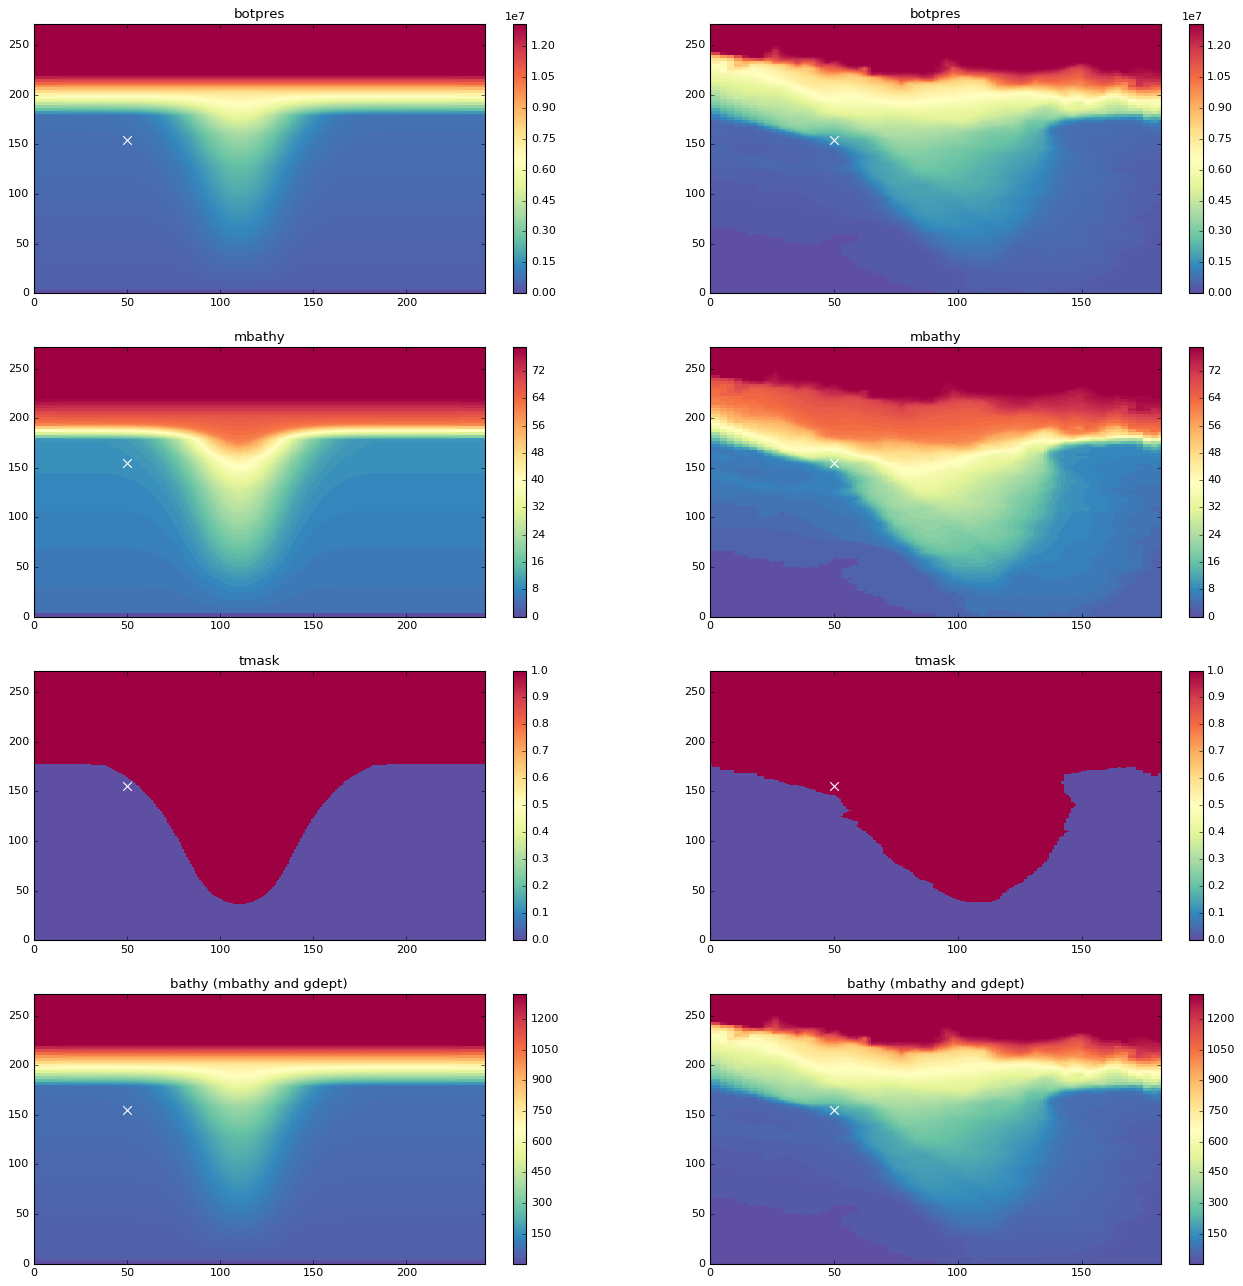

In [7]:
fig, (axA, axB, axC, axD) = plt.subplots(4, 2, figsize=(20, 20))
    
def this_subplot(ax, n, plot, ttl):
    p = ax[n].pcolormesh(plot, cmap=cm.Spectral_r)
    fig.colorbar(p, ax=ax[n])
    ax[n].set_title(ttl)
    ax[n].set_ylim([0, plot.shape[-2]])
    ax[n].set_xlim([0, plot.shape[-1]])
    ax[n].scatter(50, 155, c='w', s=60, marker='x')
    
for n, plot in zip(np.arange(2), [botpresI[0, ...], botpresR[0, ...]]):
    this_subplot(axA, n, plot, 'botpres')
    
for n, plot in zip(np.arange(2), [mbathyI, mbathyR]):
    this_subplot(axB, n, plot, 'mbathy')
    
for n, plot in zip(np.arange(2), [tmaskI[9, ...], tmaskR[9, ...]]):
    this_subplot(axC, n, plot, 'tmask')
    
for n, plot in zip(np.arange(2), [bathI, bathR]):
    this_subplot(axD, n, plot, 'bathy (mbathy and gdept)')

In [8]:
tmaskI[9, 155, 50], tmaskR[9, 155, 50]

(0, 1)

In [9]:
mbathyI[155, 50], mbathyR[155, 50]

(9, 22)

In [10]:
tmaskI[9, 155, 50], tmaskR[22, 155, 50]

(0, 0)

In [11]:
botpresI.shape, mbathyI.shape, tmaskI.shape, e2tI.shape, gdeptI.shape, bathI.shape

((480, 272, 242),
 (272, 242),
 (80, 272, 242),
 (272, 242),
 (80, 272, 242),
 (272, 242))

mbathy gives the first dry cell

In [12]:
hours = 24 * 15
tot_drag_I = np.zeros(hours)

for t in range(hours):
    
    for j in range(botpresI.shape[-2]):
        for i in range(botpresI.shape[-1]-1):

            if bathI[j, i] > bathI[j, i-1]:
                tot_drag_I[t] = tot_drag_I[t] + ( botpresI[t, j, i] * ( bathI[j, i] - bathI[j, i-1] ) * e2tI[j, i] )

            elif bathI[j, i] < bathI[j, i-1]:
                tot_drag_I[t] = tot_drag_I[t] - ( botpresI[t, j, i] * ( bathI[j, i] - bathI[j, i+1] )  * e2tI[j, i] )


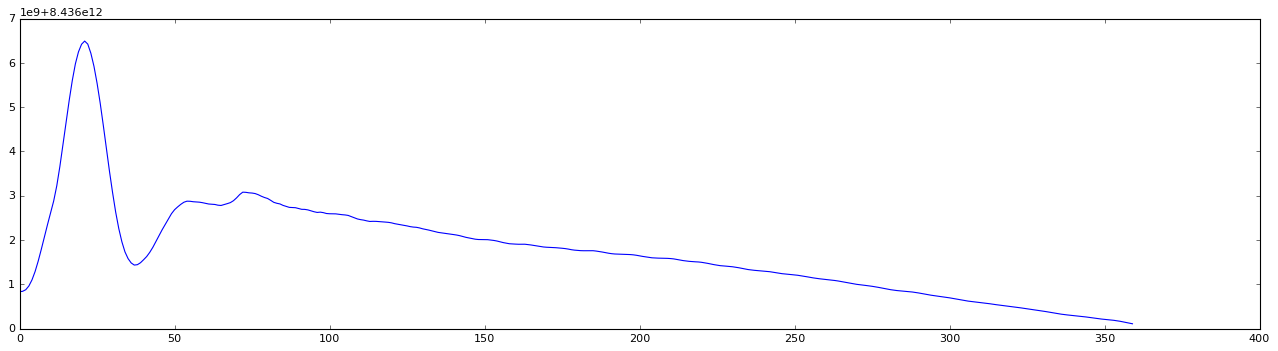

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(tot_drag_I)